In [19]:
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
from nilearn.plotting import plot_img, plot_stat_map, view_img, plot_prob_atlas
from nilearn.regions import connected_label_regions
from nilearn.glm.first_level.hemodynamic_models import spm_hrf
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.interfaces.fmriprep import load_confounds_strategy
from nilearn.plotting import plot_roi
from nilearn.maskers import NiftiMapsMasker, NiftiSpheresMasker
from nilearn import image
from nilearn.image import binarize_img
from nilearn.image import high_variance_confounds
import seaborn as sns
from nilearn.glm.first_level.design_matrix import make_first_level_design_matrix, check_design_matrix
from nilearn.masking import compute_multi_epi_mask

# Homemade functions

In [20]:
# Open a datasets directory. 
fd = os.open("/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func", os.O_RDONLY)

# Use os.fchdir() method to change the current dir/folder.
os.fchdir(fd)

# Safe check- Print current working directory
print("Current working dir : %s" % os.getcwd())

Current working dir : /Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func


## Load and check Cartmell et al. (2019) NAc Probabilistic Atlas.


In [21]:


# Define path for each segment of the atlas. 
LH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-core.nii.gz"
RH_core = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-core.nii.gz"
LH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/lh-presumed-shell.nii.gz"
RH_shell = "/Users/luisalvarez/Documents/Datasets/NAcc_ShellCore/rh-presumed-shell.nii.gz"

NAcc_files = [LH_core, RH_core, LH_shell, RH_shell]
NAcc_core_files = [LH_core, RH_core]
NAcc_shell_files = [LH_shell, RH_shell]

# Merge files into single atlas. 
NAcc_imgs = image.load_img(NAcc_files, wildcards=True)
NAcc_atlas = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs)
NAcc_atlas_masker = NiftiMapsMasker(
        maps_img=NAcc_atlas,
        allow_overlap=True)

NAcc_imgs_core = image.load_img(NAcc_core_files, wildcards=True)
NAcc_atlas_core = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_core)
NAcc_atlas_masker_core = NiftiMapsMasker(
        maps_img=NAcc_atlas_core,
        allow_overlap=True)

NAcc_imgs_shell = image.load_img(NAcc_shell_files, wildcards=True)
NAcc_atlas_shell = image.math_img('np.sum(img, axis=-1, keepdims=True)', img=NAcc_imgs_shell)
NAcc_atlas_masker_shell = NiftiMapsMasker(
        maps_img=NAcc_atlas_shell,
        allow_overlap=True)


In [22]:

NAcc_atlas_binary = binarize_img(NAcc_atlas)

/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/image.py:1071: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


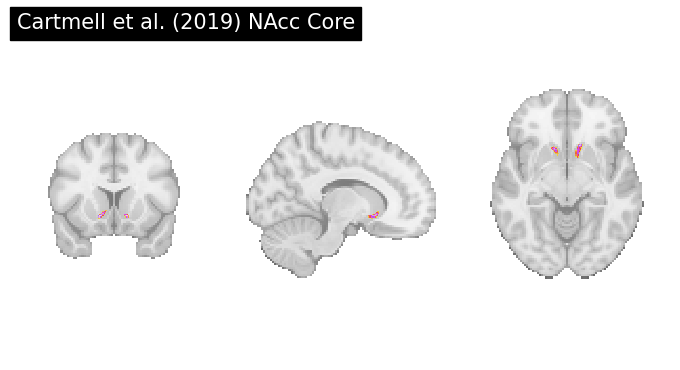

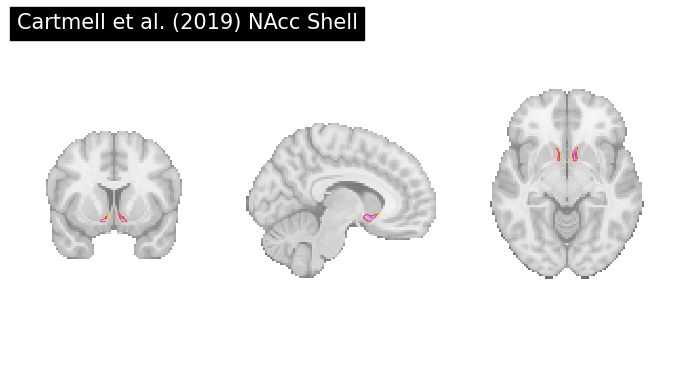

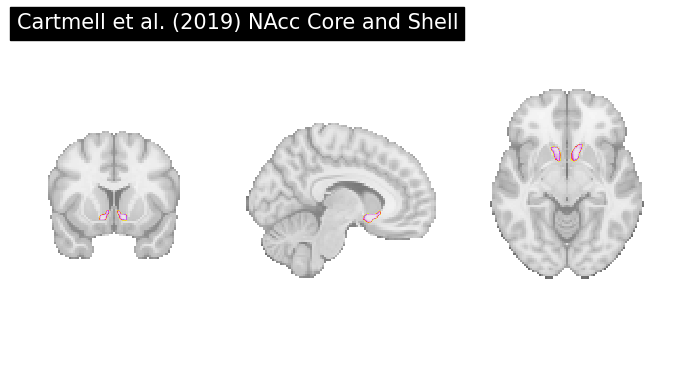

In [23]:
# Plot the atlases.
plot_roi(NAcc_atlas_core, cut_coords=None, title="Cartmell et al. (2019) NAcc Core", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas_shell, cut_coords=None, title="Cartmell et al. (2019) NAcc Shell", annotate=False, draw_cross=False)
plot_roi(NAcc_atlas, cut_coords=None, title="Cartmell et al. (2019) NAcc Core and Shell", annotate=False, draw_cross=False)


## Load fMRI files. 

In [24]:
# Load the functional files.
nii_files = glob(os.path.join(os.getcwd(), "*Gambling*.nii*"))
nii_files = sorted(nii_files)
print(nii_files)

# Load the confounds file.
confounds_files = glob(os.path.join(os.getcwd(), "*Gambling*confounds*"))
confounds_files = sorted(confounds_files)
print(confounds_files)

useful_cols = ['tx', 'ty', 'tz', 'rx', 'ry', 'rz']

confounds_files = [pd.read_csv(file, usecols=useful_cols, sep="\t") for file in confounds_files]

# Load the events file.
events_files = glob(os.path.join(os.getcwd(), "*Gambling*events*"))
events_files = sorted(events_files)
print(events_files)

# Load anatomical file.
anat_file = "/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-0/anat/sub-01_ses-00_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz"


['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_desc-confounds_timeseries.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_desc-confounds_timeseries.tsv']
['/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-ap_events.tsv', '/Users/luisalvarez/Documents/Datasets/IBC/sub-01/ses-03/func/sub-01_ses-03_task-HcpGambling_dir-pa_events.tsv']


In [25]:
# Create mask for each run.
mask_img = compute_multi_epi_mask(nii_files, upper_cutoff=.7, lower_cutoff=.4)

confounds_run1 = pd.DataFrame(high_variance_confounds(nii_files[0], percentile=5)) # mask_img=mask_img,

confounds_run1 = pd.concat([confounds_run1, confounds_files[0]], axis=1)

confounds_run2 = pd.DataFrame(high_variance_confounds(nii_files[1], mask_img=mask_img, percentile=5))

confounds_run2 = pd.concat([confounds_run2, confounds_files[1]], axis=1)

confounds_files = [confounds_run1, confounds_run2]


In [26]:
confounds_files[0]

,0,1,2,3,4,tx,ty,tz,rx,ry,rz
0,-0.029071,-0.097438,-0.051411,0.142916,-0.000564,1.421086e-14,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.079410,-0.055956,-0.068771,-0.053841,0.070702,-3.527298e-04,-0.009361,0.015562,0.000348,0.000042,0.000047
2,0.085940,0.060631,0.039980,0.119547,0.036281,-4.526497e-03,-0.001408,0.011296,0.000149,0.000023,0.000040
3,-0.027150,0.086009,0.039950,0.018605,-0.035123,-3.523057e-03,0.020809,-0.003080,0.000466,-0.000062,0.000030
4,-0.084757,-0.059539,0.013596,0.055803,0.027782,-5.850399e-03,0.013442,0.001887,0.000248,-0.000040,-0.000046
...,...,...,...,...,...,...,...,...,...,...,...
183,0.069206,0.063495,0.048438,0.061749,0.047995,-1.223419e-01,-0.021668,-0.138387,0.002663,-0.001911,-0.002191
184,-0.036728,-0.037083,0.017977,-0.057991,-0.035582,-9.553273e-02,-0.008547,-0.104818,0.003019,-0.001236,-0.002178
185,-0.061166,0.070021,0.041031,0.055324,0.112124,-8.120518e-02,-0.012865,0.035289,0.002215,-0.001269,-0.002199
186,0.031118,0.112714,0.150983,0.025578,0.011716,-9.623924e-02,-0.067303,-0.026390,0.003091,-0.001740,-0.001991


## Create GLM model.

In [27]:
#bg_img=anat_img

In [28]:
# Create GLM object. 
fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    hrf_model="spm + derivative",
    high_pass= 1/128,
    slice_time_ref=0.5,
    mask_img=mask_img,
    smoothing_fwhm=5)

#drift_model="cosine",



In [29]:
# Fit GLM model. Note it requires as input the fmri file, the events dataframe, and the confounds dataframe. 
fmri_glm_gamble = fmri_glm.fit(nii_files[0], events_files[0], confounds_files[0])



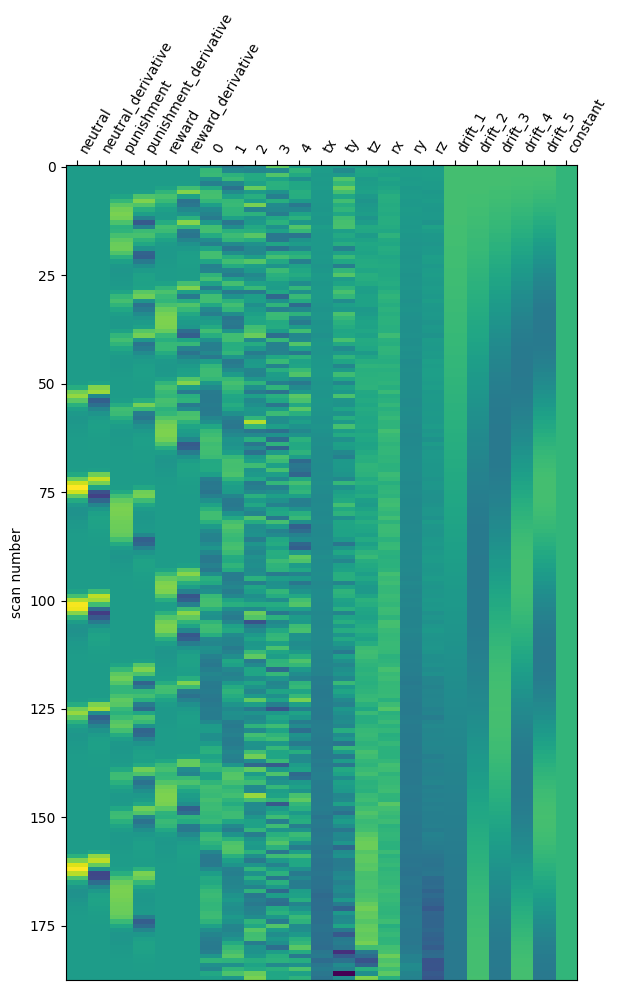

In [30]:
plot_design_matrix(fmri_glm_gamble.design_matrices_[0])

plt.show()

FDR p<0.05 threshold: 3.670


/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)


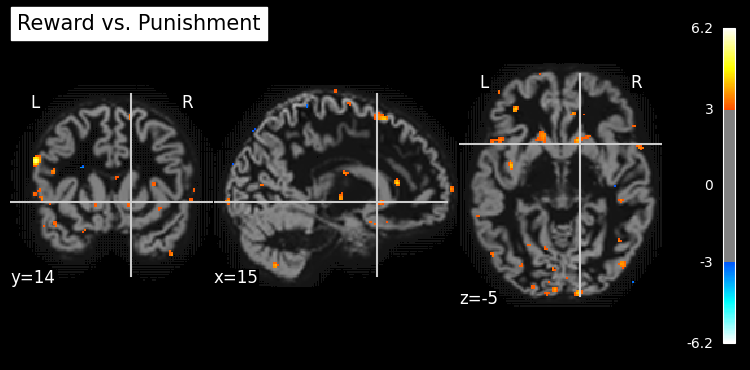

In [38]:
# Create the orthogonal contrast to the create image. Note, the sum of all elements equals zero.
reward_minus_punishment = "+1*reward-1*punishment"

reward_minus_punishment_z_map = fmri_glm_gamble.compute_contrast(contrast_def=reward_minus_punishment, stat_type="t", output_type="z_score")

reward_minus_punishment_thresholded_map, threshold = threshold_stats_img(reward_minus_punishment_z_map, alpha=0.05, height_control="fdr", cluster_threshold=5)
print(f"FDR p<0.05 threshold: {threshold:.3f}")
plot_stat_map(
    reward_minus_punishment_z_map,
    threshold=3,#3,
    cut_coords=[15, 14, -5],
    bg_img=anat_file,
    title="Reward vs. Punishment"
)
plt.show()

In [32]:
"""
reward_minus_punishment_NAcc_shell =  NAcc_atlas_masker.fit_transform(reward_minus_punishment_z_map)
"""


'\nreward_minus_punishment_NAcc_shell =  NAcc_atlas_masker.fit_transform(reward_minus_punishment_z_map)\n'

In [33]:
reward_minus_punishment_NAcc =  NAcc_atlas_masker.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_inv =  NAcc_atlas_masker.inverse_transform(reward_minus_punishment_NAcc)

reward_minus_punishment_NAcc_core =  NAcc_atlas_masker_core.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_core_inv =  NAcc_atlas_masker_core.inverse_transform(reward_minus_punishment_NAcc_core)

reward_minus_punishment_NAcc_shell =  NAcc_atlas_masker_shell.fit_transform(reward_minus_punishment_z_map)
reward_minus_punishment_NAcc_shell_inv =  NAcc_atlas_masker_shell.inverse_transform(reward_minus_punishment_NAcc_shell)



/Users/luisalvarez/opt/anaconda3/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:536: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  data = safe_get_data(anat_img, ensure_finite=True)


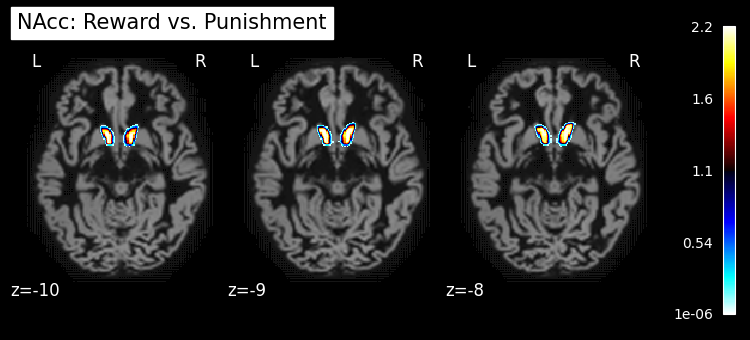

In [34]:
plot_stat_map(
    reward_minus_punishment_NAcc_inv,
    #threshold=0.1,
    display_mode="z",
    cut_coords=3,
    bg_img=anat_file,
    #black_bg=True,
    title="NAcc: Reward vs. Punishment"
)
plt.show()

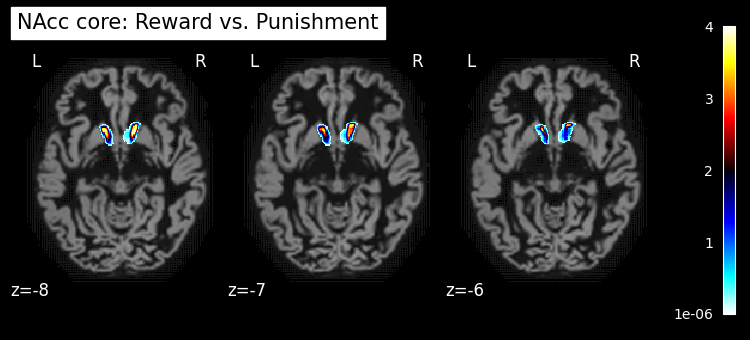

In [35]:
plot_stat_map(
    reward_minus_punishment_NAcc_core_inv,
    #threshold=0.1,
    display_mode="z",
    cut_coords=3,
    bg_img=anat_file,
    #black_bg=True,
    title="NAcc core: Reward vs. Punishment"
)
plt.show()

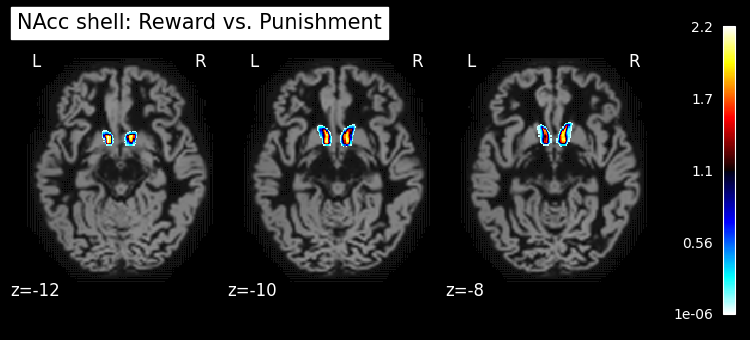

In [36]:
plot_stat_map(
    reward_minus_punishment_NAcc_shell_inv,
    #threshold=0.1,
    display_mode="z",
    cut_coords=3,
    bg_img=anat_file,
    #black_bg=True,
    title="NAcc shell: Reward vs. Punishment"
)
plt.show()